## Inteligență Artificială Tema 1 - 2025: Sokoban

Responsabili:

- Andrei Olaru
- Cătălin Chiru
- Andrei Dugăeșescu
- Mihai Nan
- Vlad Matei Drăghici
- Alexandru Baciu
- Bogdan-Andrei Sprîncenatu


In [155]:
from sokoban import Map, save_images, create_gif
from time import time

import matplotlib.pyplot as plt
import numpy as np

# Solving a map


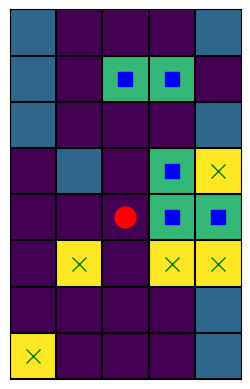

In [150]:
playmap = Map.from_yaml("tests/super_hard_map1.yaml")
# playmap = Map(5, 5, 0, 0, [('box1', 0, 2), ('box2', 2, 2)], [(1, 2), (2, 2)], [], 'easy_map1')
playmap.plot_map()

# A

In [ ]:
from sokoban.moves import BOX_LEFT


def filter_possible_moves_without_pulls(state: Map) -> list[int]:
    moves = state.filter_possible_moves()
    filtered_moves = []

    for move in moves:
        if move < BOX_LEFT:
            filtered_moves.append(move)
            continue

        

    return filtered_moves

def expand_state(state: Map) -> list[Map]:
    moves = state.filter_possible_moves()
    print(moves)
    new_states = []

    for move in moves:
        new_state = state.copy()
        new_state.apply_move(move)
        new_states.append(new_state)

    return new_states


import queue


def in_bounds(state: Map, x: int, y: int) -> bool:
    return x >= 0 and y >= 0 and x < state.length and y < state.width


def dist(a, b):
    return abs(a.x - b[0]) + abs(a.y - b[1])


def costf(state: Map, distances: list[list[int]]) -> tuple[int, ...]:
    target_distances = 0
    player_distances = []

    for box in state.boxes.values():
        x, y = box.x, box.y
        target_distances += distances[box.x][box.y]

        box_vicinities = [[(x - 1, y), (x + 1, y)], [(x, y - 1), (x, y + 1)]]
        box_pos = []
        for axis in box_vicinities:
            valid = True

            for neigh in axis:
                if not in_bounds(state, neigh[0], neigh[1]) or state.map[neigh[0]][
                    neigh[1]
                ] in [
                    1,
                    2,
                ]:  # [box, obstacle]
                    valid = False
                    break

            if valid:
                box_pos += axis

        d = lee(state, [(state.player.x, state.player.y)], [1, 2])

        if len(box_pos) == 0:
            if distances[box.x][box.y] != 0:
                return tuple([1000])

            continue

        dd = min(map(lambda p: d[p[0]][p[1]], box_pos))
        player_distances.append(dd)

    player_distances.sort()
    sort_key = tuple([target_distances, *player_distances])
    return sort_key


def lee(state: Map, starts: list[tuple[int, int]], invalid_values: list[int]):
    goal_distances = list(map(lambda r: list(map(lambda _: 100, r)), state.map))

    q = queue.Queue()
    for x, y in starts:
        goal_distances[x][y] = 0
        q.put((x, y))

    while not q.empty():
        x, y = q.get()

        for x2, y2 in [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]:
            if not in_bounds(state, x2, y2):
                continue

            if state.map[x2][y2] in invalid_values:  # OBSTACLE
                continue

            if (
                goal_distances[x2][y2] == -1
                or goal_distances[x2][y2] > goal_distances[x][y] + 1
            ):
                goal_distances[x2][y2] = goal_distances[x][y] + 1
                q.put((x2, y2))

    return goal_distances

In [ ]:
def astar(state: Map):
        

astar(playmap)

# LRTA\*


In [ ]:
from random import choice


def astar(state: Map):

    def h(state: Map, goal_distances):
        player = state.player
        return goal_distances[player.x][player.y]

    # goal_distances = lee(state, state.targets, [1])
    goal_distances = [
        [8, 1000, 1000, 1000, 1000],
        [7, 1000, 1000, 1000, 1000],
        [6, 1000, 1000, 1000, 1000],
        [5, 1000, 1000, 1000, 1000],
        [4, 3, 2, 1, 0],
    ]
    cost_estimations = {}

    for i in goal_distances[::-1]:
        print(i)

    Result = {}

    def Cost(src, move):
        key = (src.__str__(), move)

        if key not in Result:
            return h(src, goal_distances)

        dst = Result[key]
        return 1 + cost_estimations[dst.__str__()]

    moves = []

    prev_state = None
    prev_move = None

    for _ in range(100):
        state.plot_map()

        if state.is_solved():
            print("gata")
            return

        state_encoding = state.__str__()

        if state_encoding not in cost_estimations:
            cost_estimations[state_encoding] = h(state, goal_distances)
            print(cost_estimations)
            if cost_estimations[state_encoding] == 0:
                print(moves)
                save_images(moves, ".")
                create_gif(".", "Solution", ".")
                return  # FIXME

        if prev_state is not None:
            prev_state_encoding = prev_state.__str__()
            Result[(prev_state_encoding, prev_move)] = state_encoding

            prev_state_moves = expand_state(prev_state)
            cost_estimations[prev_state_encoding] = min(
                map(lambda move: Cost(prev_state, move), prev_state_moves)
            )

        next_moves = state.filter_possible_moves()
        move = [next_moves[0]]
        cost = Cost(state, move[0])

        for candidate in next_moves[1:]:
            candidate_cost = Cost(state, candidate)

            if candidate_cost < cost:
                move = [candidate]
                cost = candidate_cost
            elif candidate_cost == cost:
                move.append(candidate)

        move = choice(move)

        prev_state = state.copy()
        prev_move = move

        print("Moved ", move)
        state.apply_move(move)
        moves.append(state.__str__())

        # neigh_states = expand_state(state)
        # next_costs = []
        # for state in neigh_states:
        #     encoding = state.__str__()
        #     cost = 0

        #     if encoding not in cost_estimations:
        #         cost = sum(costf(state, goal_distances))
        #         cost_estimations[encoding] = cost
        #     else:
        #         cost = cost_estimations[encoding]

        #     next_costs.append((1 + cost, state))

        # cost, next_state = min(next_costs)
        # cost_estimations[state.__str__()] = cost
        # state = next_state


astar(playmap.copy())

# Beam search


euristica 21


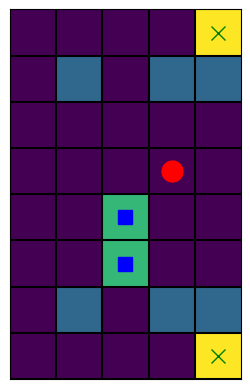

GIF saved at: ./Try.gif


In [166]:
from typing import Callable, Sequence

from tempfile import mkdtemp
from shutil import rmtree

def save_play(moves: list[Map | str], name: str, path: str="."):
    tmpdir = mkdtemp()
    save_images(moves, tmpdir)
    create_gif(tmpdir, name, path)
    rmtree(tmpdir)

def boxes_placed(state: Map) -> int:
    cost = 0

    for target in state.targets:
        if target not in state.positions_of_boxes:
            cost += 1
    
    return cost

def boxes_total_distance(state: Map) -> int:
    free_targets = []
    boxes_on_target = set()

    for target in state.targets:
        if target not in state.positions_of_boxes:
            free_targets.append(target)
            continue

        box_name = state.positions_of_boxes[target]
        boxes_on_target.add(box_name)

    if len(free_targets) == 0:
        return 0
    
    goal_distances = lee(state, free_targets, [1])

    cost = 0
    if len(free_targets) > 1:
        for i in range(len(free_targets)):
            goal_distances2 = lee(state, free_targets[:i] + free_targets[i + 1:], [1])
            target_distance = 0

            for box in state.boxes.values():
                if box.name in boxes_on_target:
                    continue

                target_distance = max(target_distance, goal_distances2[box.x][box.y])
        
            cost += target_distance
        

    for box in state.boxes.values():
        if box.name in boxes_on_target:
            continue

        target_distance = goal_distances[box.x][box.y]
        cost += target_distance

    return cost

def beam_search(state: Map, heuristic: Callable[[Map], int], k: int, max_iters: int = 100) -> list[Map | str] | None:
    beam = [([], state)]

    for _ in range(max_iters):
        beam_children = []
        children_costs = []

        for child in beam:
            history, state = child
            history.append(state.__str__())

            if state.is_solved():
                return history

            children = state.get_neighbours()
            children = list(filter(lambda x: x.undo_moves <= state.undo_moves, children))
            
            costs = list(map(lambda x: heuristic(x), children))
            children = list(map(lambda x: (history.copy(), x), children))
            
            beam_children += children
            children_costs += costs
        
        costs = np.array(children_costs)
        costs = np.exp(costs.max() - costs)
        costs /= costs.sum()

        xs = np.random.choice(range(len(costs)), min(k, len(costs)), replace=False, p=costs)
        beam = [beam_children[i] for i in xs]

    print("euristica",heuristic(beam[0][1]))
    beam[0][1].plot_map()
    save_play(beam[0][0], "Try", ".")
    
beam_search(playmap.copy(), boxes_total_distance, 70, 100)

In [157]:
difficulties = ['easy', 'medium', 'hard']
variants = ['1', '2']

tests = [f'tests/{difficulty}_map{variant}.yaml' for difficulty in difficulties for variant in variants]

GIF saved at: ./easy_map1.gif
GIF saved at: ./easy_map2.gif
euristica 1


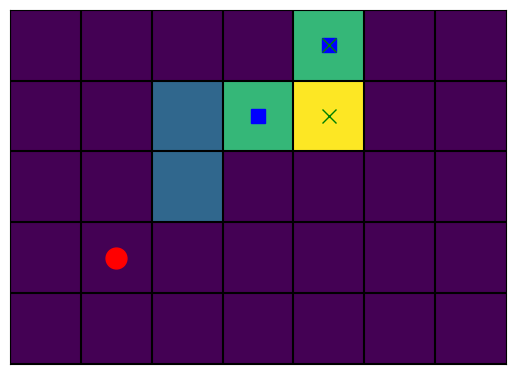

GIF saved at: ./Try.gif
euristica 2


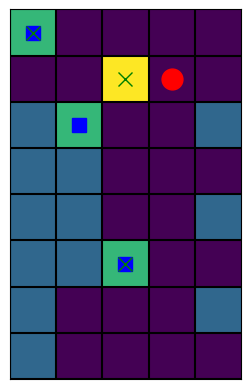

GIF saved at: ./Try.gif
euristica 6


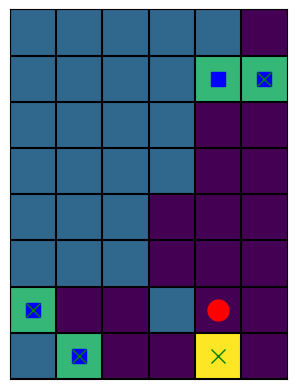

GIF saved at: ./Try.gif
euristica 22


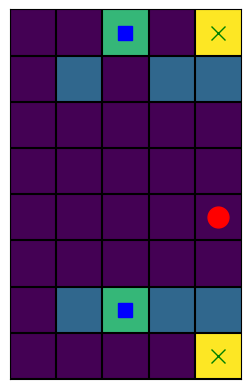

GIF saved at: ./Try.gif


In [167]:
for test in tests:
    playmap = Map.from_yaml(test)
    play = beam_search(playmap.copy(), boxes_total_distance, 70, 100)
    if play is not None:
        save_play(play, test.split('/')[-1].split('.')[0], ".")

max= 6
max= 6
max= 6
max= 7
max= 7
max= 7
max= 8
max= 7
max= 7
max= 7
max= 6
max= 7
max= 6
max= 5
max= 6
max= 3
max= 4
max= 5
max= 4
max= 3
max= 2
max= 3
max= 2
GIF saved at: ./Solution.gif
max= 6
max= 6
max= 6
max= 7
max= 6
max= 6
max= 6
max= 5
max= 4
GIF saved at: ./Solution.gif
max= 15
max= 15
max= 18
max= 18
max= 18
max= 15
max= 12
max= 15
max= 12
max= 8
max= 8
max= 8
GIF saved at: ./Solution.gif
max= 18
max= 17
max= 19
max= 23
max= 19
max= 23
max= 19
max= 23
max= 16
max= 19
max= 14
max= 19
max= 19
max= 14
max= 19
max= 9
max= 19
max= 7
max= 13
max= 7
max= 10
max= 10
max= 10
max= 10
max= 18
max= 7
max= 18
max= 10
max= 18
max= 5
max= 18
max= 5
max= 18
GIF saved at: ./Solution.gif
max= 24
max= 24
max= 25
max= 26
max= 25
max= 26
max= 27
max= 26
max= 27
max= 20
max= 30
max= 20
max= 30
max= 20
max= 30
max= 14
max= 30
max= 20
max= 30
max= 20
max= 30
max= 20
max= 30
max= 20
max= 30
max= 20
max= 30
max= 14
max= 30
max= 20
max= 30
max= 20
max= 30
max= 14
max= 14
max= 14
max= 12
max= 14
max= 

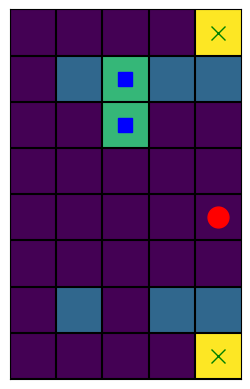

GIF saved at: ./Try.gif


Text(0.5, 1.0, 'Execution times for different test files')

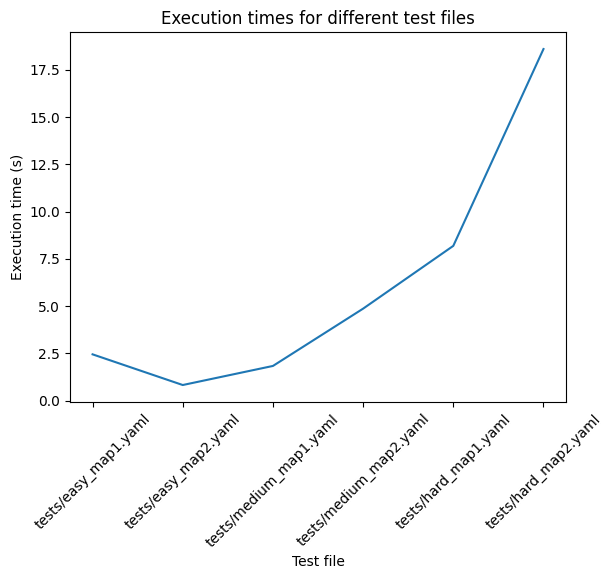

In [159]:
execution_times = []

for test in tests:
    playmap = Map.from_yaml(test)
    
    start = time()
    beam_search(playmap.copy(), boxes_total_distance, 70, 100)    
    end = time()

    execution_times.append(end - start)

plt.plot(execution_times)
#i want to plot execution times in seconds against file name
plt.xticks(range(len(tests)), tests, rotation=45)
plt.xlabel('Test file')
plt.ylabel('Execution time (s)')
plt.title('Execution times for different test files')

In [ ]:
from random import choices


class Play:
    def __init__(self, state: Map, prev_history: list[str] = []):
        self.history = [*prev_history, state.__str__()]
        self.state = state

    def advance(self, state: Map):
        next_state = Play(state, prev_history=self.history)
        return next_state

    def save(self):
        save_images(self.history, ".")
        create_gif(".", "Solution", ".")


def beam_search(state: Map, k: int):
    goal_distances = lee(state, state.targets, [1])

    cst = lambda c: costf(c, goal_distances)
    beam = expand_state(state)

    x = Play(state)
    beam = list(map(lambda state: x.advance(state), beam))

    for i in range(50):
        print(f"round {i}: best candidate score {cst(beam[0].state)}")
        beam[0].state.plot_map()

        beam_candidates = []

        for b in beam:
            state = b.state

            if state.is_solved():
                print("game won")
                b.save()
                return

            new_states = expand_state(state)
            new_states = list(map(lambda s: b.advance(s), new_states))
            beam_candidates += new_states

        candidate_weights = list(map(lambda x: sum(cst(x.state)), beam_candidates))
        total = sum(candidate_weights)
        candidate_weights = list(map(lambda x: x / total, candidate_weights))
        beam = choices(beam_candidates, weights=candidate_weights, k=k)


beam_search(playmap, 300)